## Classification

Here we test different classification algorithms for the generated graph measures dataset. **Section 3.6** of the report describes the algorithms and results.

In [1]:
import numpy as np

In [2]:
import random 
random.seed(20)

In [3]:
import matplotlib
# Set backend to pgf
matplotlib.use('pgf')
import matplotlib.pyplot as plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
#plt.gray()

In [4]:
%matplotlib inline

In [5]:
from scipy.io import loadmat

In [6]:
from pylab import *

In [7]:
from sklearn.pipeline import Pipeline

In [8]:
from sklearn import preprocessing

In [9]:
from sklearn import cross_validation

In [10]:
from sklearn.cross_validation import cross_val_score

In [11]:
from sklearn.cross_validation import LeaveOneOut

In [12]:
from sklearn import svm

In [13]:
from sklearn.feature_selection import SelectKBest

In [14]:
from sklearn.feature_selection import chi2

In [15]:
from sklearn import metrics

In [16]:
# set random Seed
randomSeed = 20;

# TODO: Change accordingly
CONNECTIVITY_MEASURE = 'dWPLI'
DATASETS_FOLDER = '/home/dragos/DTC/MSc/SummerProject/processed_data/features/'
DATASETS_FOLDER = DATASETS_FOLDER + CONNECTIVITY_MEASURE + '/full_graph/datasets/'
nameOfDataFileMat = 'datasetFullGraphMeasures.mat'
nameOfDataFileCSV = 'datasetFullGraphMeasures.csv'

In [17]:
# threshold vector
thresholdVec = [0.05, 0.1, 0.15, 0.2, 0.3]

### Visualisation with t-SNE and PCA

Some data visualisation using [t-SNE](https://lvdmaaten.github.io/tsne/) and [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis). t-SNE is explained in **Section 3.6.1** of the report.

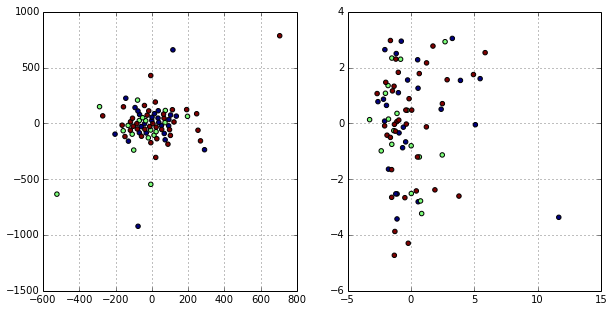

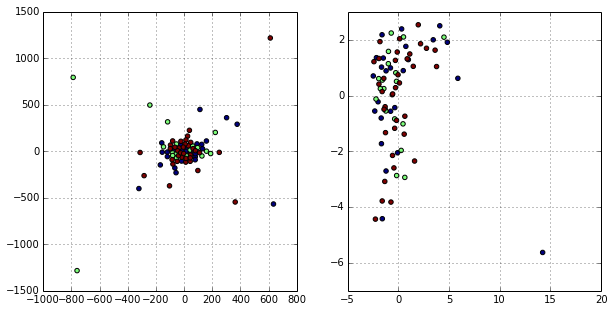

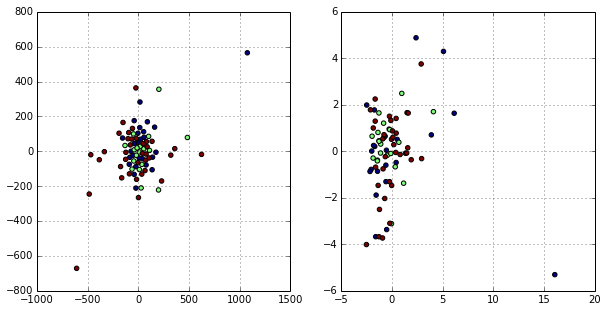

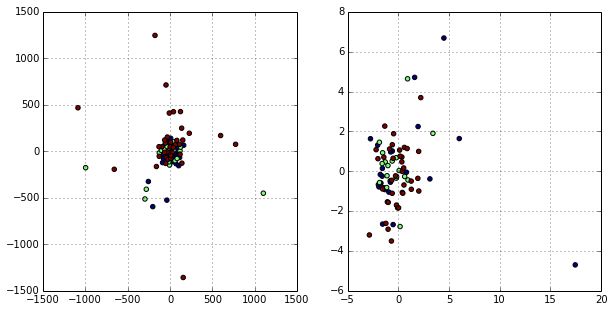

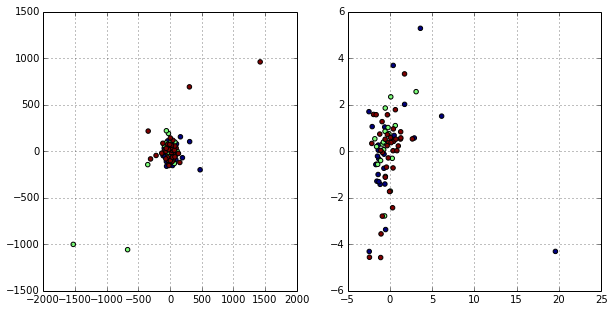

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


for threshold in thresholdVec:

    data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFile

    # load dataset 
    data_dict = loadmat(data_file_path)
    data = data_dict['dataset']
    theThreshold = data_dict['threshold']

    n_samples = data.shape[0]
    features = data[:, :-1]
    targets = data[:, -1]
    
    scaler = preprocessing.StandardScaler().fit(features)
    X_SCL = scaler.transform(features)


    model = TSNE(n_components=2, random_state=0)
    #model = TSNE(learning_rate=100)

    X_TSNE = model.fit_transform(X_SCL)
    X_PCA = PCA().fit_transform(X_SCL) 

    figure(figsize=(10, 5))
    subplot(121)
    scatter(X_TSNE[:, 0], X_TSNE[:, 1], c=targets)
    subplot(122)
    scatter(X_PCA[:, 0], X_PCA[:, 1], c=targets)

### Implementation of the SMOTE Algorithm

See: [SMOTE: synthetic minority over-sampling technique](https://www.jair.org/media/953/live-953-2037-jair.pdf) by Chawla, N.V et al.

Link to [code](https://github.com/blacklab/nyan/blob/master/shared_modules/smote.py) below.

In [20]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
The MIT License (MIT)
Copyright (c) 2012-2013 Karsten Jeschkies <jeskar@web.de>

Permission is hereby granted, free of charge, to any person obtaining a copy of 
this software and associated documentation files (the "Software"), to deal in 
the Software without restriction, including without limitation the rights to use, 
copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the 
Software, and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all 
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION 
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
'''

'''
Created on 24.11.2012

@author: karsten jeschkies <jeskar@web.de>

This is an implementation of the SMOTE Algorithm. 
See: "SMOTE: synthetic minority over-sampling technique" by
Chawla, N.V et al.
'''
import logging
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors

logger = logging.getLogger("main")

def SMOTE(T, N, k, h = 1.0):
    """
    Returns (N/100) * n_minority_samples synthetic minority samples.

    Parameters
    ----------
    T : array-like, shape = [n_minority_samples, n_features]
        Holds the minority samples
    N : percetange of new synthetic samples: 
        n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    k : int. Number of nearest neighbours. 

    Returns
    -------
    S : Synthetic samples. array, 
        shape = [(N/100) * n_minority_samples, n_features]. 
    """    
    n_minority_samples, n_features = T.shape
    
    if N < 100:
        #create synthetic samples only for a subset of T.
        #TODO: select random minortiy samples
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N must be < 100 or multiple of 100")
    
    N = N/100
    
    n_synthetic_samples = N * n_minority_samples
    S = np.zeros(shape=(n_synthetic_samples, n_features))
    
    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    
    #Calculate synthetic samples
    for i in xrange(n_minority_samples):
        nn = neigh.kneighbors(T[i], return_distance=False)
        for n in xrange(N):
            nn_index = choice(nn[0])
            #NOTE: nn includes T[i], we don't want to select it 
            while nn_index == i:
                nn_index = choice(nn[0])
                
            dif = T[nn_index] - T[i]
            gap = np.random.uniform(low = 0.0, high = h)
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    
    return S

def borderlineSMOTE(X, y, minority_target, N, k):
    """
    Returns synthetic minority samples.

    Parameters
    ----------
    X : array-like, shape = [n__samples, n_features]
        Holds the minority and majority samples
    y : array-like, shape = [n__samples]
        Holds the class targets for samples
    minority_target : value for minority class
    N : percetange of new synthetic samples: 
        n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    k : int. Number of nearest neighbours. 
    h : high in random.uniform to scale dif of snythetic sample

    Returns
    -------
    safe : Safe minorities
    synthetic : Synthetic sample of minorities in danger zone
    danger : Minorities of danger zone
    """ 
    
    n_samples, _ = X.shape

    #Learn nearest neighbours on complete training set
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(X)
    
    safe_minority_indices = list()
    danger_minority_indices = list()
    
    for i in xrange(n_samples):
        if y[i] != minority_target: continue
        
        nn = neigh.kneighbors(X[i], return_distance=False)

        majority_neighbours = 0
        for n in nn[0]:
            if y[n] != minority_target:
                majority_neighbours += 1
                
        if majority_neighbours == len(nn):
            continue
        elif majority_neighbours < (len(nn)/2):
            logger.debug("Add sample to safe minorities.")
            safe_minority_indices.append(i)
        else:
            #DANGER zone
            danger_minority_indices.append(i)
            
    #SMOTE danger minority samples
    synthetic_samples = SMOTE(X[danger_minority_indices], N, k, h = 0.5)
    
    return (X[safe_minority_indices],
            synthetic_samples, 
            X[danger_minority_indices])


### SMOTE

For each threshold, generate new samples for underrepresented classes (MCI and CS) using [SMOTE](https://www.jair.org/media/953/live-953-2037-jair.pdf), append them to the initial dataset and store them in the *SMOTE_data* dictionary.

In [21]:
SMOTE_data = dict()


for threshold in thresholdVec:
    data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFile

    # load dataset 
    data_dict = loadmat(data_file_path)
    data = data_dict['dataset']
    theThreshold = data_dict['threshold']

    features = data[:, :-1]
    targets = data[:, -1]
    
    
    ### SMOTE - generate synthetic samples
    k = 5
        
    classIdxsCS = np.where(targets == 1)
    classFeaturesCS = features[classIdxsCS]
    CSsynth = SMOTE(classFeaturesCS, 38.46, k, h = 1.0) # get 10 synt samples
    CSsynth = CSsynth[:10,:] # slice for the first 10
    
    classIdxsMCI = np.where(targets == 2)
    classFeaturesMCI = features[classIdxsMCI]
    MCIsynth = SMOTE(classFeaturesMCI, 100, k, h = 1.0) # get 18 synt samples
    
    ## concatenate original samples with synthetic ones
    features = np.concatenate((features, CSsynth, MCIsynth), axis=0)
    CStargetssyn = np.full( (CSsynth.shape[0], ), 1)
    MCItargetssyn = np.full( (MCIsynth.shape[0], ), 2)
    targets = np.concatenate((targets, CStargetssyn, MCItargetssyn), axis=0)
    
    SMOTE_data[threshold] = (features, targets)

In [22]:
print(SMOTE_data.keys())

[0.2, 0.3, 0.15, 0.1, 0.05]


### Dummy Classifier

Use a dummy classifier as a simple baseline for comparison with other models. The strategy of the dummy classifier is to choose the most frequent class.

In [23]:
from sklearn.dummy import DummyClassifier

model = Pipeline([
    ('scaler', preprocessing.StandardScaler() ),
    ('clf', DummyClassifier(strategy='most_frequent', random_state=randomSeed))
    ])
    
for threshold in thresholdVec:
        
    data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFile

    # load dataset 
    data_dict = loadmat(data_file_path)
    data = data_dict['dataset']
    theThreshold = data_dict['threshold']

    n_samples = data.shape[0]
    features = data[:, :-1]
    targets = data[:, -1]

    loo = LeaveOneOut(n_samples)
    p = []
    t = []
    for train,test in loo:
        model.fit(features[train], targets[train])
        p.append(model.predict(features[test]))
        t.append(targets[test])   
   
    p=vstack(p)
    
    target_Classes = ['CS', 'MCI', 'AD']
    print(metrics.confusion_matrix(t,p))
    print(metrics.classification_report(t,p, labels=[1,2,3],target_names=target_Classes))
    
    

[[ 0  0 26]
 [ 0  0 18]
 [ 0  0 36]]
             precision    recall  f1-score   support

         CS       0.00      0.00      0.00        26
        MCI       0.00      0.00      0.00        18
         AD       0.45      1.00      0.62        36

avg / total       0.20      0.45      0.28        80

[[ 0  0 26]
 [ 0  0 18]
 [ 0  0 36]]
             precision    recall  f1-score   support

         CS       0.00      0.00      0.00        26
        MCI       0.00      0.00      0.00        18
         AD       0.45      1.00      0.62        36

avg / total       0.20      0.45      0.28        80

[[ 0  0 26]
 [ 0  0 18]
 [ 0  0 36]]
             precision    recall  f1-score   support

         CS       0.00      0.00      0.00        26
        MCI       0.00      0.00      0.00        18
         AD       0.45      1.00      0.62        36

avg / total       0.20      0.45      0.28        80

[[ 0  0 26]
 [ 0  0 18]
 [ 0  0 36]]
             precision    recall  f1-score   sup

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Look at different classifier performances such as:

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ('scaler', preprocessing.StandardScaler() ),
    ('clf', LogisticRegression(C=1, random_state=randomSeed))
    ])

for threshold in thresholdVec:
    data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFile

    # load dataset 
    data_dict = loadmat(data_file_path)
    data = data_dict['dataset']
    theThreshold = data_dict['threshold']

    n_samples = data.shape[0]

    features = data[:, :-1]
    targets = data[:, -1]
   
    loo = LeaveOneOut(n_samples)

    p = []
    t = []
    for train,test in loo:

        model.fit(features[train], targets[train])
        p.append(model.predict(features[test]))
        t.append(targets[test])  

    p=vstack(p)
    
    target_Classes = ['CS', 'MCI', 'AD']
    print(metrics.confusion_matrix(t,p))
    print(metrics.classification_report(t,p, labels=[1,2,3],target_names=target_Classes)) 

[[13  2 11]
 [ 4  3 11]
 [10  3 23]]
             precision    recall  f1-score   support

         CS       0.48      0.50      0.49        26
        MCI       0.38      0.17      0.23        18
         AD       0.51      0.64      0.57        36

avg / total       0.47      0.49      0.47        80

[[13  3 10]
 [ 6  2 10]
 [ 9  6 21]]
             precision    recall  f1-score   support

         CS       0.46      0.50      0.48        26
        MCI       0.18      0.11      0.14        18
         AD       0.51      0.58      0.55        36

avg / total       0.42      0.45      0.43        80

[[10  4 12]
 [ 5  2 11]
 [ 9  5 22]]
             precision    recall  f1-score   support

         CS       0.42      0.38      0.40        26
        MCI       0.18      0.11      0.14        18
         AD       0.49      0.61      0.54        36

avg / total       0.40      0.42      0.41        80

[[ 9  5 12]
 [ 5  0 13]
 [ 9  6 21]]
             precision    recall  f1-score   sup

### Logistic Regression with SMOTE

In [25]:
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ('scaler', preprocessing.StandardScaler() ),
    ('clf', LogisticRegression(C=1, random_state=randomSeed))
    ])

for threshold in thresholdVec:
    
    # load dataset from SMOTE_data dictionary
    features = SMOTE_data[threshold][0]
    targets = SMOTE_data[threshold][1]
       
    n_samples = features.shape[0]
    
    loo = LeaveOneOut(n_samples)

    p = []
    t = []
    for train,test in loo:

        model.fit(features[train], targets[train])
        p.append(model.predict(features[test]))
        t.append(targets[test])  

    p=vstack(p)
   
    print(metrics.confusion_matrix(t,p))
    print(metrics.classification_report(t,p, labels=[1,2,3],target_names=target_Classes))   

[[25  4  7]
 [ 7 20  9]
 [ 8 11 17]]
             precision    recall  f1-score   support

         CS       0.62      0.69      0.66        36
        MCI       0.57      0.56      0.56        36
         AD       0.52      0.47      0.49        36

avg / total       0.57      0.57      0.57       108

[[24  5  7]
 [ 8 21  7]
 [10  9 17]]
             precision    recall  f1-score   support

         CS       0.57      0.67      0.62        36
        MCI       0.60      0.58      0.59        36
         AD       0.55      0.47      0.51        36

avg / total       0.57      0.57      0.57       108

[[15 11 10]
 [11 17  8]
 [11 10 15]]
             precision    recall  f1-score   support

         CS       0.41      0.42      0.41        36
        MCI       0.45      0.47      0.46        36
         AD       0.45      0.42      0.43        36

avg / total       0.44      0.44      0.44       108

[[21  7  8]
 [ 4 20 12]
 [10 13 13]]
             precision    recall  f1-score   sup

## SVMs

In [41]:
from sklearn.grid_search import GridSearchCV

for threshold in thresholdVec:
    #threshold = 0.05
    
    data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFile

    # load dataset 
    data_dict = loadmat(data_file_path)
    data = data_dict['dataset']
    theThreshold = data_dict['threshold']

    n_samples = data.shape[0]
    features = data[:, :-1]
    targets = data[:, -1]

    #cv = cross_validation.ShuffleSplit(n_samples, n_iter=n_samples,
    #                test_size=1, random_state=randomSeed)

    param_grid = [
      {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
      {'C': [1, 10, 100, 1000], 'gamma': np.logspace(-4, 0, 5), 'kernel': ['rbf']},
     ]
    #pprint(param_grid)
    
    loo = LeaveOneOut(n_samples)

    gs_svc = GridSearchCV(svm.SVC(C=1), param_grid, cv=loo)
    gs_svc.fit(features, targets)
    print(gs_svc.best_score_)
    #clf = svm.SVC(kernel='rbf')
    #clf = svm.SVC(kernel='rbf', C=100, gamma=0.001)
    #clf = svm.SVC(kernel='rbf', C=10, gamma=0.005)
    #print(clf.get_params())
    #clf.fit(features[:-1], targets[:-1])
    #scores = cross_validation.cross_val_score(gs_svc, features, targets, cv=loo)

    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    #print("\n")

## Multi-class AdaBoosted Decision Trees

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

model = Pipeline([
    ('scaler', preprocessing.StandardScaler() ),
    ('clf', AdaBoostClassifier(
            DecisionTreeClassifier(),   # max_depth=2 in example
            n_estimators=300,           # 600 in example
            learning_rate=1,
            random_state=randomSeed))
    ])

for threshold in thresholdVec:
    
    data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFile

    # load dataset 
    data_dict = loadmat(data_file_path)
    data = data_dict['dataset']
    theThreshold = data_dict['threshold']

    n_samples = data.shape[0]
    features = data[:, :-1]
    targets = data[:, -1]
    
           
    bdt_real = AdaBoostClassifier(
            DecisionTreeClassifier(),   # max_depth=2 in example
            n_estimators=300,           # 600 in example
            learning_rate=1)
    bdt_discrete = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=2),
            n_estimators=300,
            learning_rate=1.5,
            algorithm="SAMME")
        
    loo = LeaveOneOut(n_samples)
    
    p = []
    t = []
    for train,test in loo:

        model.fit(features[train], targets[train])
        p.append(model.predict(features[test]))
        t.append(targets[test])  

    p=vstack(p)
   
    target_Classes = ['CS', 'MCI', 'AD']
    print(metrics.confusion_matrix(t,p))
    print(metrics.classification_report(t,p, labels=[1,2,3],target_names=target_Classes))

[[ 9  4 13]
 [ 4  6  8]
 [11 11 14]]
             precision    recall  f1-score   support

         CS       0.38      0.35      0.36        26
        MCI       0.29      0.33      0.31        18
         AD       0.40      0.39      0.39        36

avg / total       0.37      0.36      0.36        80

[[10  4 12]
 [ 5  6  7]
 [10  8 18]]
             precision    recall  f1-score   support

         CS       0.40      0.38      0.39        26
        MCI       0.33      0.33      0.33        18
         AD       0.49      0.50      0.49        36

avg / total       0.42      0.42      0.42        80

[[14  2 10]
 [ 5  5  8]
 [13  8 15]]
             precision    recall  f1-score   support

         CS       0.44      0.54      0.48        26
        MCI       0.33      0.28      0.30        18
         AD       0.45      0.42      0.43        36

avg / total       0.42      0.42      0.42        80

[[ 9  7 10]
 [ 8  3  7]
 [12  9 15]]
             precision    recall  f1-score   sup

## Multi-class AdaBoosted Decision Trees with SMOTE

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

model = Pipeline([
    ('scaler', preprocessing.StandardScaler() ),
    ('clf', AdaBoostClassifier(
            DecisionTreeClassifier(),   # max_depth=2 in example
            n_estimators=300,           # 600 in example
            learning_rate=1,
            random_state=randomSeed))
    ])

for threshold in thresholdVec:
    data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFile

    # load dataset from SMOTE_data dictionary
    features = SMOTE_data[threshold][0]
    targets = SMOTE_data[threshold][1]    
   
    n_samples = features.shape[0]
    loo = LeaveOneOut(n_samples)
     
    #bdt_discrete = AdaBoostClassifier(
    #        DecisionTreeClassifier(max_depth=2),
    #        n_estimators=300,
    #        learning_rate=1,
    #        algorithm="SAMME")
    
    p = []
    t = []
    for train,test in loo:
        model.fit(features[train], targets[train])
        p.append(model.predict(features[test]))
        t.append(targets[test])  

    p=vstack(p)
    
    target_Classes = ['CS', 'MCI', 'AD']
    print(metrics.confusion_matrix(t,p))
    print(metrics.classification_report(t,p, labels=[1,2,3],target_names=target_Classes))

[[22  3 11]
 [ 1 24 11]
 [11  8 17]]
             precision    recall  f1-score   support

         CS       0.65      0.61      0.63        36
        MCI       0.69      0.67      0.68        36
         AD       0.44      0.47      0.45        36

avg / total       0.59      0.58      0.59       108

[[16  8 12]
 [ 9 21  6]
 [16  9 11]]
             precision    recall  f1-score   support

         CS       0.39      0.44      0.42        36
        MCI       0.55      0.58      0.57        36
         AD       0.38      0.31      0.34        36

avg / total       0.44      0.44      0.44       108

[[14 11 11]
 [ 7 23  6]
 [12  7 17]]
             precision    recall  f1-score   support

         CS       0.42      0.39      0.41        36
        MCI       0.56      0.64      0.60        36
         AD       0.50      0.47      0.49        36

avg / total       0.50      0.50      0.50       108

[[25  6  5]
 [11 19  6]
 [ 7 11 18]]
             precision    recall  f1-score   sup

## Random Forest Classifier

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([
    ('scaler', preprocessing.StandardScaler() ),
    ('clf', RandomForestClassifier(
            n_estimators=200,
            random_state=randomSeed)
     )
    ])

for threshold in thresholdVec:
    
    # load dataset 
    data_dict = loadmat(data_file_path)
    data = data_dict['dataset']
    theThreshold = data_dict['threshold']

    n_samples = data.shape[0]
    features = data[:, :-1]
    targets = data[:, -1] 
   
    n_samples = features.shape[0]
    loo = LeaveOneOut(n_samples)
    
    p = []
    t = []
    for train,test in loo:
        model.fit(features[train], targets[train])
        p.append(model.predict(features[test]))
        t.append(targets[test])  

    p=vstack(p)
    
    target_Classes = ['CS', 'MCI', 'AD']
    print(metrics.confusion_matrix(t,p))
    print(metrics.classification_report(t,p, labels=[1,2,3], target_names=target_Classes)) 
   
    

[[12  0 14]
 [ 3  0 15]
 [ 6  1 29]]
             precision    recall  f1-score   support

         CS       0.57      0.46      0.51        26
        MCI       0.00      0.00      0.00        18
         AD       0.50      0.81      0.62        36

avg / total       0.41      0.51      0.44        80

[[12  0 14]
 [ 3  0 15]
 [ 6  1 29]]
             precision    recall  f1-score   support

         CS       0.57      0.46      0.51        26
        MCI       0.00      0.00      0.00        18
         AD       0.50      0.81      0.62        36

avg / total       0.41      0.51      0.44        80

[[12  0 14]
 [ 3  0 15]
 [ 6  1 29]]
             precision    recall  f1-score   support

         CS       0.57      0.46      0.51        26
        MCI       0.00      0.00      0.00        18
         AD       0.50      0.81      0.62        36

avg / total       0.41      0.51      0.44        80

[[12  0 14]
 [ 3  0 15]
 [ 6  1 29]]
             precision    recall  f1-score   sup

## Random Forest Classifier with SMOTE data

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([
    ('scaler', preprocessing.StandardScaler() ),
    ('clf', RandomForestClassifier(
            n_estimators=200,
            random_state=randomSeed)
     )
    ])

for threshold in thresholdVec:

    # load dataset from SMOTE_data dictionary
    features = SMOTE_data[threshold][0]
    targets = SMOTE_data[threshold][1]    
   
    n_samples = features.shape[0]
    loo = LeaveOneOut(n_samples)
    
    p = []
    t = []
    for train,test in loo:
        model.fit(features[train], targets[train])
        p.append(model.predict(features[test]))
        t.append(targets[test])  

    p=vstack(p)
    
    target_Classes = ['CS', 'MCI', 'AD']
    print(metrics.confusion_matrix(t,p))
    print(metrics.classification_report(t,p, labels=[1,2,3], target_names=target_Classes)) 
   
    

[[27  1  8]
 [ 1 28  7]
 [ 6 10 20]]
             precision    recall  f1-score   support

         CS       0.79      0.75      0.77        36
        MCI       0.72      0.78      0.75        36
         AD       0.57      0.56      0.56        36

avg / total       0.69      0.69      0.69       108

[[25  6  5]
 [ 1 31  4]
 [ 7 10 19]]
             precision    recall  f1-score   support

         CS       0.76      0.69      0.72        36
        MCI       0.66      0.86      0.75        36
         AD       0.68      0.53      0.59        36

avg / total       0.70      0.69      0.69       108

[[25  3  8]
 [ 2 29  5]
 [ 8  7 21]]
             precision    recall  f1-score   support

         CS       0.71      0.69      0.70        36
        MCI       0.74      0.81      0.77        36
         AD       0.62      0.58      0.60        36

avg / total       0.69      0.69      0.69       108

[[24  4  8]
 [ 2 29  5]
 [ 6 10 20]]
             precision    recall  f1-score   sup